# Introduction and Data Gathering

In [1]:
import numpy as np
import pandas as pd

# navigating directories

import os
from natsort import natsorted

# working with strings

import re
from fuzzywuzzy import fuzz
from langdetect import detect

# plotting

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# downloading files
from concurrent.futures import ThreadPoolExecutor
import requests

# extracting features from MIDI files

import music21

# webscraping

import scrapy
from scrapy.crawler import CrawlerProcess

sns.set_style('darkgrid')

# General Introduction

The lute is a stringed instrument that enjoyed great popularity during the Renaissance and was still widely used in the Baroque period. It has an incredibly large repertoire, but much of it is still inaccessible because it remains hidden in historical books and treatises scattered across hundreds of libraries and collections. The dataset we will examine for this project was created by Sarge Gerbode, a private lute enthusiast who has made it his mission to digitize these works and make them publicly available. For this purpose, he takes scans of historical documents that contain lute music from libraries and collections to encode the pieces using the music notation program Fromino. Fromino is a piece of software designed for typesetting early music in tablature, the (family of) musical notation that was used for lute music. He puts the results on his website and documents his work in an excel spreadsheet each row of which represents one piece encoded in Fromino. The columns of the spreadsheet contain information about the title, composer, source, etc. of the pieces, as well as links to the files exported from Fromino: files in Fromino's own format, PDF scores and MIDI files.

Here you find Gerbode's website
+ https://www.lutemusic.org

And here the Fromino software
+ https://sites.google.com/view/fronimo/home

The dataset is definitely interesting for people who are curious about early music, as it covers an important part of Western music history for which datasets usually take the form of books and are therefore difficult to process using statistical or computational methods.  Regarding its reliability, it should be noted that it was not created to serve as material for musicological research. Its main purpose is to make the works of Renaissance lute composers accessible to music performers. Therefore, we should assume that it is not a representative sample and contains some errors or inaccuracies here and there.

In what follows, I will first provide a brief overview of the dataset and its important variables, and then outline the plan for the project.

In [131]:
wd = os.getcwd()
lute_data_path = os.path.join(wd, 'data', 'data_sets', 'lute_data.csv')
lute_df = pd.read_csv(lute_data_path)

lute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20426 entries, 0 to 20425
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           20232 non-null  object 
 1   Subtitle        8388 non-null   object 
 2   Composer        20251 non-null  object 
 3   Orig. composer  4007 non-null   object 
 4   Source          20424 non-null  object 
 5   Document        20426 non-null  object 
 6   Volume          4388 non-null   object 
 7   Date            20426 non-null  object 
 8   Page            19750 non-null  object 
 9   Editor          20426 non-null  object 
 10  Encoder         20426 non-null  object 
 11  Arranger        2160 non-null   object 
 12  Intabulator     106 non-null    object 
 13  Contributor     0 non-null      float64
 14  Concordances    239 non-null    object 
 15  Piece           8812 non-null   object 
 16  Section         689 non-null    object 
 17  Type            20420 non-null 

### Variables of Interest

The dataset has a little over 20000 entries. The number of actual pieces, however, is probably less since sometimes there exist multiple versions of the same piece. If we are considering, for example, a piece for soprano voice with lute accompaniment, there might be one version that contains both the voice and the lute part and another version that contains only the lute part. Also, we will mostly look at subsets of the whole dataset.

The dataset includes 30 columns, but most of them are not interesting for us. We will only use the following columns, which are explained in more detail below.

+ Title
+ Composer
+ Document
+ Date
+ Type
+ Key
+ Ensemble
+ PDF
+ Midi

### Title

This column contains the titles of the pieces. It's not really important for the analysis, but sometimes it's nice to have the ability to identify an individual piece. For instance, if you're looking at a particular metric and you're interested in how some popular piece scores in that regard. Or when you see that a piece stands out in some respect, and want to listen to a recording.

### Composer

This column contains the names of the composers of the pieces. The variable will be one of the more imporant ones for this project. In total there are 703 unique entries in the composer column, the most common being "Anonymous" for pieces where the composer is unknown. Next are John Dowland, probably the most prominent representative of English lute music, and Hans Newsidler, an early German-Hungarian lutenist.

In [132]:
lute_df.Composer.value_counts().head(5)

Composer
Anonymous               4717
John Dowland             917
Hans Newsidler           472
Thomas Campion           399
Joachim van den Hove     389
Name: count, dtype: int64

### Document

This column contains the names of the documents from which the pieces are taken. It's a diverse collection of books and treatises including both hand-written and printed sources, private notes and published works and so on. The well-known or important documents sometimes have names like "Intavolatura di Liuto", others have more cryptic identifiers that can probably be deciphered by librarians or music historians. We will use it to establish connections between composers by looking at whose compositions were published along with whose. There are 557 unique entries in the document column.

In [133]:
print('Unique documents:',
      len(lute_df.Document.unique()),
      '\n')

lute_df.Document.value_counts().head(5)

Unique documents: 557 



Document
ms ii.6.15:Dlugorai lute book     575
Thesaurus Harmonicus              502
ms F.IX.70:Wurstisen lute book    489
Dd.2.11b                          473
Airs de Differents Auteurs        466
Name: count, dtype: int64

### Date

This column contains the date when the document containing the piece was published. It currently has the datatype "object" because some entries contain non-numeric characters (for instance, "c." if the exact year in unknown). We retain only the numeric parts and convert it to integers. If we look at the distribution, we can see that lute music was published from around 1500 and reached a peak in the late Renaissance around 1600. In the following Baroque period, the lute was still in use, but we have much fewer pieces in our dataset. This does not necessarily reflect a historical development, but rather the fact that the encoder focuses mainly on Renaissance music. We also have some outliers -- probably mostly arrangements of older or modern pieces.

In [134]:
lute_df['Date'] = lute_df['Date'].str.replace('[^0-9]','', regex=True).astype(int)

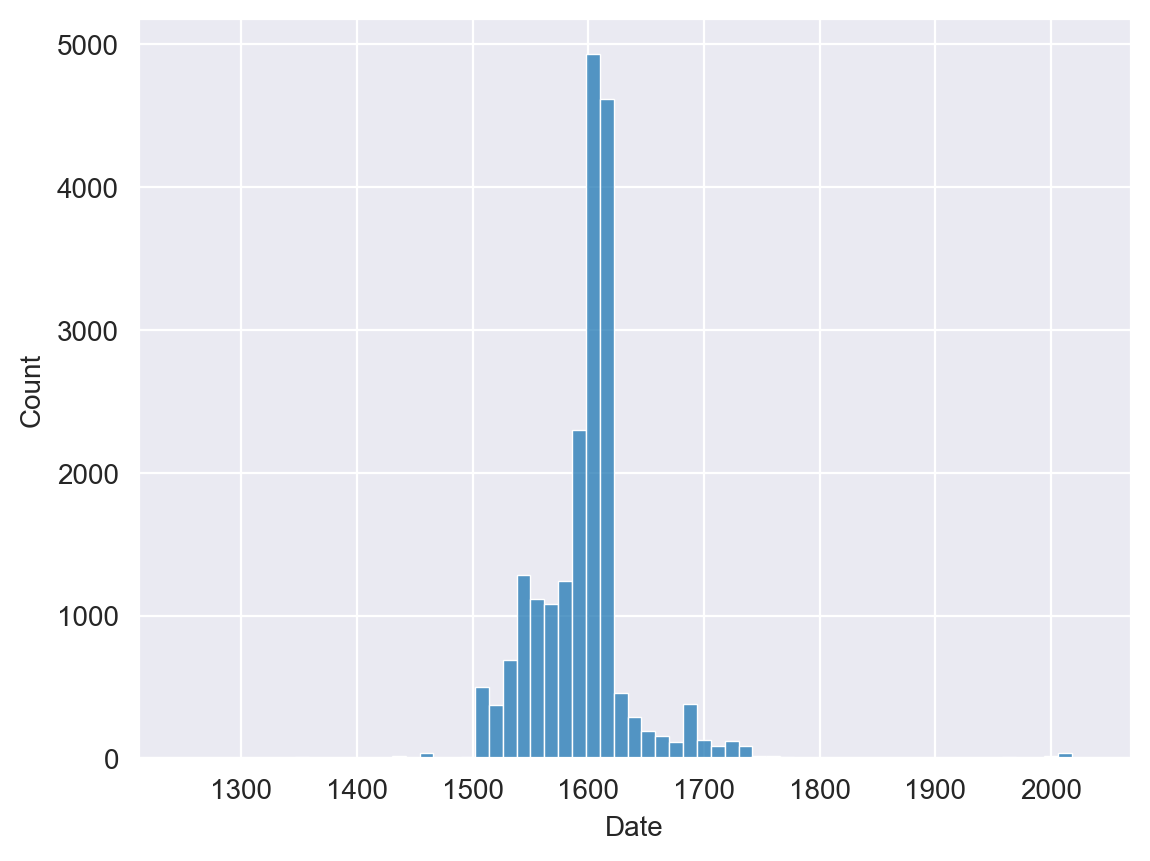

In [135]:
sns.histplot(x='Date', data=lute_df, binwidth=12)
plt.show()

### Type

This column specifies what kind of piece we are dealing with. The most common type are lute songs, i.e. pieces for one or more voices with lute accompaniment (possibly with other instruments as well). Other important types of pieces are various kinds of intabulations (lute arrangements of (polyphonic) vocal music), dance pieces such as galliards, pavanes, courantes, allemandes, etc., and freer forms of often virtuosic soloistic pieces such as ricercars, fantasias, toccatas, etc.

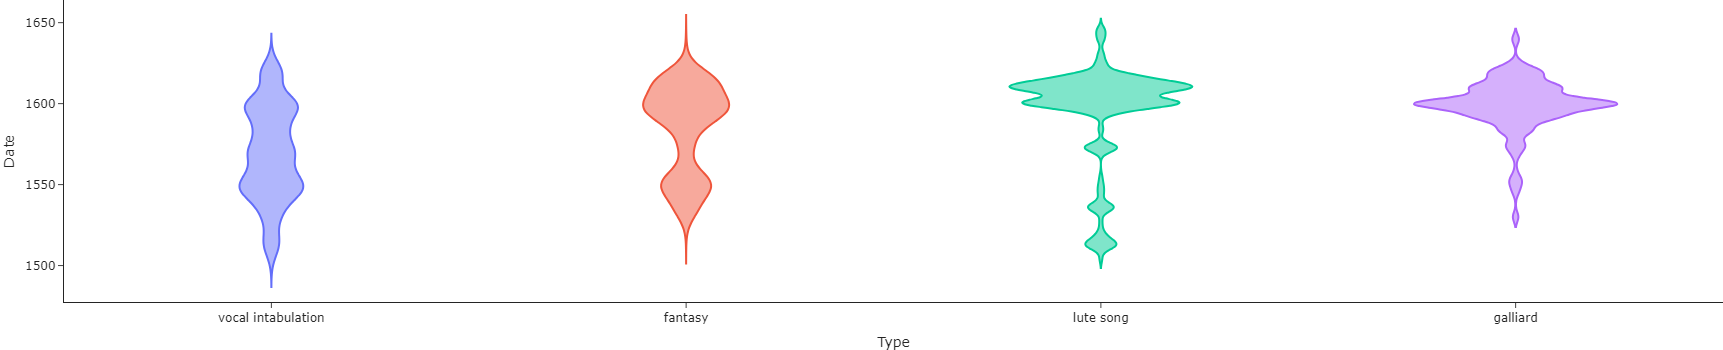

In [163]:
imp_types = ['vocal intabulation',  'fantasy', 'lute song', 'galliard']

category_orders = {'Type':imp_types}

#lute_df['Type'] = lute_df['Type'].apply(lambda x: 'fantasia' if x == 'fantasy' else x)

lute_df['Type'] = lute_df['Type'].apply(lambda x: 'vocal intabulation' if x in ['vocal intabulation, religious', 'vocal intabulation, chanson', 'vocal intabulation, madrigal', 'vocal intabulation, lied'] else x)

fig = px.violin(
    lute_df.query("Date > 1490 and Date < 1650 and Type in @imp_types"),
    y="Date",
    x="Type",
    color="Type",
    category_orders=category_orders,
    points=False
)

fig.update_layout(
    height=350,
    width=550,
     margin=dict(l=0,r=0,b=0,t=0),
    template='simple_white',
    showlegend=False
)

fig.write_html(os.path.join(wd, 'plots_and_tables', 'types_violinplot.html'))

fig.show()

### Key

This column contains the musical keys of the pieces.

In [8]:
lute_df.Key.value_counts().head(5)

Key
FM    3786
Gm    3651
GM    2278
Cm    2052
Dm    1990
Name: count, dtype: int64

### Ensemble

This column contains the instrumentation of the pieces. Since lutes are double strung, we count their courses (pairs of strings). This means the most common type of renaissance-lute, the 6-course lute, has 6 pairs of strings. We will use this variable primarily to subset our dataset so that it contains only music for solo lute. But while we're at it, we might as well take a look at the distribution of pieces over time by type of lute. It looks like they added more and more strings to the instrument over time.

In [9]:
lute_df.Ensemble.value_counts().head(10)

Ensemble
6-course                                7929
7-course                                3143
8-course                                1174
10-course                                679
9-course                                 620
6-course, alto                           339
lute 1:6-course, lute 2:6-course         334
6-course, soprano                        285
10-course, voice                         222
6-course, bass, tenor, alto, soprano     178
Name: count, dtype: int64

### Midi and PDF

These columns contain links to the MIDI files and PDF sheet music of the pieces.

In [10]:
for link in lute_df.head().Midi:
    print(link)

https://lutemusic.org/midi/01_lobet_den_herren_alle_heiden_dresslerG.mid
https://lutemusic.org/midi/068_anon_old_long_syne.mid
https://lutemusic.org/composers/Abel/midi/sonata_CM_01_moderato.mid
https://lutemusic.org/composers/Abel/midi/sonata_CM_01_moderato_T.mid
https://lutemusic.org/composers/Abel/midi/sonata_CM_02_minuetto.mid


In [11]:
for link in lute_df.head().PDF:
    print(link)

https://lutemusic.org/pdf/01_lobet_den_herren_alle_heiden_dresslerG.pdf
https://lutemusic.org/pdf/068_anon_old_long_syne.pdf
https://lutemusic.org/composers/Abel/pdf/sonata_CM_01_moderato.pdf
https://lutemusic.org/composers/Abel/pdf/sonata_CM_01_moderato_T.pdf
https://lutemusic.org/composers/Abel/pdf/sonata_CM_02_minuetto.pdf


### Plan of the Project

Now that we've seen what material we have, we need a plan for what we're going to do with it. The problem is that so far there is not much we can do since we only have a couple categorical variables. But it's now easy to see how we can use the material we have to get more data we can then work with. In particular, we will

+ download the MIDI files and extract muscial features such as range and tempo,
+ use online databases to get additional information about the composers,
+ and download the PDF scores of lute songs to get some text data.

We will use this data to

+ compare two composers with respect to the musical features of their pieces,
+ take a closer look at the composers, where they lived and how they are connected,
+ and to do a quick sentiment analysis of English lute songs.

Thus, we have three analyses with their respective data collection parts, which are explained in more detail below.

**MIDI Features:** The first analysis can be found in the Notebook "1_composer_comparison". In this part we take advantage of the fact that we have access to the MIDI files of the pieces. We  pick two composers -- the Italian lute virtuoso Francesco da Milano and the German-Hungarian lutenist Hans Newsidler. Our goal is to build a logistic regression model that uses musical features such as range and tempo to distinguish between the two composers. This is an explanatory rather than a predictive task: which musical features best explain the differences between the compositional styles of the two composers? As a first step, we download the MIDIs and use the Python library music21 to extract relevant musical features from them. We then do a quick exploratory analysis and use Lasso regression to select the most important features for our model. Finally, we build and interpret the regression model.

**Composer Data and Network Graph:** The second analysis is divided into two notebooks, one for the data collection (2_1_scrape_composer_data) and one for the actual analysis (2_2_composer_migration_and_publication_network). In the first notebook, we obtain some information (namely town, country, and date of birth and death) about the composers in our dataset by scraping two online composer databases. In the second notebook, we use this information to map the migration flow of composers between countries and the places where they worked. Next, we explore connections between composers by creating and exploring a network graph in which composers serve as nodes and are connected by an edge if there is a historical publication that contains pieces of both composers.

**Sentiment Analysis:** For the final analysis (3_text_extraction_and_sentiment_analysis), we download the PDF scores of all lute songs in our dataset. Recall that lute songs are pieces for voice and lute accompaniment. Therefore, some of them contain one or more verses of text. We convert the PDFs to text files and attempt to extract the lyrics of the English lute songs. Then, we use a pre-trained text classification model to assign emotion scores to the songs. Using these scores, we identify the most emotional pieces, compare composers, and see if pieces in minor keys have sadder lyrics than those in major keys.

# Download Files

In [ ]:
def download_files(df, file_type):  
    """
    This function takes a DataFrame containing URLs of a specific file type (Midi, PDF, Fronimo) and downloads the corresponding files to a specified directory.
    The files are named based on the DataFrame's index, ensuring uniqueness.
    """
    def download_file(url, index):
        response = requests.get(url)
        filepath = os.path.join(wd, 'data', f'{file_types[file_type]}_files', f'{index}.{file_types[file_type]}')
        with open(filepath, mode="wb") as f:
            f.write(response.content)
            
    file_types = {'Midi':'mid', 'PDF':'pdf', 'Fronimo':'ft3'}
            
    if file_type not in file_types:
        raise ValueError(f'Invalid file type: {file_type}')    
    
    urls = df[file_type].to_list()
    
    with ThreadPoolExecutor() as executor:
        executor.map(download_file, urls, df.index.to_list())

# Extract Features from MIDIs

In [12]:
lute_df_midi = lute_df.dropna(axis=0, how='any', subset=['Midi']).copy()

In [8]:
def extract_features(df, csv_name):
    
    # create a list of paths to the MIDI files
    
    midi_folder_path = os.path.join(wd, 'data', 'mid_files')
    
    filepaths = []
    for file in os.listdir(midi_folder_path):
        filepath = os.path.join(midi_folder_path, file)
        filepaths.append(filepath)      
    filepaths = natsorted(filepaths)
    
    # instead of class labels, we add the index column of the input dataframe to the DataSet
    # this way, we can easily and without risking any errors merge the extracted data with the original dataframe 
    
    ds = music21.features.DataSet(classLabel='index')
    f = [music21.features.jSymbolic.AmountOfArpeggiationFeature,
         music21.features.jSymbolic.AverageNoteDurationFeature,
         music21.features.jSymbolic.AverageTimeBetweenAttacksFeature,
         music21.features.jSymbolic.ChangesOfMeterFeature,
         music21.features.jSymbolic.ChromaticMotionFeature,
         music21.features.jSymbolic.DurationFeature,
         music21.features.jSymbolic.ImportanceOfBassRegisterFeature,
         music21.features.jSymbolic.ImportanceOfHighRegisterFeature,
         music21.features.jSymbolic.ImportanceOfMiddleRegisterFeature,
         music21.features.jSymbolic.InitialTempoFeature,
         music21.features.jSymbolic.InitialTimeSignatureFeature,
         music21.features.jSymbolic.MaximumNoteDurationFeature,
         music21.features.jSymbolic.MelodicTritonesFeature,
         music21.features.jSymbolic.MinimumNoteDurationFeature,
         music21.features.jSymbolic.NoteDensityFeature,
         music21.features.jSymbolic.NumberOfPitchedInstrumentsFeature,
         music21.features.jSymbolic.PitchClassVarietyFeature,
         music21.features.jSymbolic.PitchVarietyFeature,
         music21.features.jSymbolic.PrimaryRegisterFeature,
         music21.features.jSymbolic.RangeFeature,
         music21.features.jSymbolic.RepeatedNotesFeature,
         music21.features.jSymbolic.VariabilityOfNoteDurationFeature,
         music21.features.native.DiminishedSeventhSimultaneityPrevalence,
         music21.features.native.DiminishedTriadSimultaneityPrevalence,
         music21.features.native.DominantSeventhSimultaneityPrevalence,
         music21.features.native.LandiniCadence,
         music21.features.native.MajorTriadSimultaneityPrevalence,
         music21.features.native.MinorTriadSimultaneityPrevalence,
         music21.features.native.QualityFeature,
         music21.features.native.RangeOfNoteQuarterLengths,
         music21.features.native.TonalCertainty,
         music21.features.native.TriadSimultaneityPrevalence]
    
    ds.addFeatureExtractors(f)
    ds.addMultipleData(filepaths, classValues=df.index)
    ds.process()
    
    csv_path = os.path.join(wd, 'data', 'data_sets', csv_name)

    ds.write(fp=csv_path, format='csv', includeClassLabel=True)

In [17]:
# load feature data

feature_data_path = os.path.join(wd, 'data', 'data_sets', 'midi_features.csv')
feature_data = pd.read_csv(feature_data_path)

# merge original dataset with feature data

feature_data = feature_data.set_index('index')
df = lute_df_midi.merge(feature_data, how='left', left_index=True, right_index=True)

In [18]:
# create a single time signature varible from the two variables (numerator, denominator) created by music21 feature extraction

df['Initial_Time_Signature'] = df['Initial_Time_Signature_0'].astype(int).astype(str) \
                               + '/' + df['Initial_Time_Signature_1'].astype(int).astype(str)
df = df.drop(['Initial_Time_Signature_0', 'Initial_Time_Signature_1'], axis=1)

# we drop all rows with key signatures that occur less than 5 times since most of them don't fit the naming convention

df = df[df.Key.isin(df.Key.value_counts().index[:22])]

# some midi files are defective (luckily not many though), so we couldn't extract any data

df = df[df.Duration!=0]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20306 entries, 2 to 20425
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Title                                       20112 non-null  object 
 1   Subtitle                                    8285 non-null   object 
 2   Composer                                    20132 non-null  object 
 3   Orig. composer                              3928 non-null   object 
 4   Source                                      20304 non-null  object 
 5   Document                                    20306 non-null  object 
 6   Volume                                      4336 non-null   object 
 7   Date                                        20306 non-null  int32  
 8   Page                                        19631 non-null  object 
 9   Editor                                      20306 non-null  object 
 10  Encoder        

In [21]:
lute_data_midi_path = os.path.join(wd, 'data', 'data_sets', 'lute_data_midi_features.csv')

df.to_csv(lute_data_midi_path)

# Web Scraping Composer Data

### Cleaning

We start by importing the main dataset and using it to create a dataset that has the unique composer names as both its index and as its only column. We then export this dataframe as a csv file to manually clean the composer names.

In [29]:
# prepare dataframe with unique composer names for subsequent manual cleaning

df_comp = lute_df[['Composer']]
df_comp = df_comp.drop_duplicates()
df_comp = df_comp.dropna()

df_comp = df_comp.set_index('Composer', drop=False)
df_comp.columns = ['cleaned_name']
df_comp = df_comp.drop(index='Anonymous', axis=0)

# write to csv, so we can work with it in excel

df_comp_path = os.path.join(wd, 'data', 'data_sets', 'composers_to_clean.csv')
df_comp.to_csv(df_comp_path, sep=',')

Now we do some manual cleaning where possible. This is done outside of the Notebook. In particular, we

+ fill in missing special characters (e.g. accented chars in french and spanish names)
+ changed mysterious abbreviations like "V.H.S." to Anonymous
+ changed entries of the format "composer_1 or composer_2" to Anonymous
+ spelled out or deleted some abbreviated (middle) names
+ removed "?" after composers of pieces whose authorship is uncertain

Next we import the dataset with the manually cleaned names.

In [66]:
# import manually cleaned composer names

path_cleaned = os.path.join(wd, 'data', 'data_sets', 'cleaned_composers.csv')
df_comp_cleaned = pd.read_csv(path_cleaned, encoding="latin-1")

df_comp_cleaned.head(5)

,Composer,cleaned_name
0,Karl Friedrich Abel,Karl Friedrich Abel
1,Lodovico Agostini,Lodovico Agostini
2,Giovanni J. Albuzio,Giovanni Giacopo Albuzio
3,Richard Allison,Richard Allison
4,Serafino Aquilano,Serafino Aquilano


In [31]:
print('Unique composers after cleaning:', len(df_comp_cleaned.cleaned_name.unique()))

Unique composers after cleaning: 550


By doing steps like deleting uninformative abbreviations, we have reduced our initial ~700 composer names down to only 550.

### Scraping

Now we create two dictionaries to store the data scraped from the two websites and a list of unique cleaned composer names so that we can give them as input for our scraping procedure. To allow you to try it out quickly, I have just included the first 25 names in the list. As always the full results are already available in the data_sets folder.

In [35]:
# dicts to store data

composer_data_classical = {}
composer_data_musicalics = {'birth':{}, 'group':{}, 'death':{}}

Now we can finally scrape our websites. For this, we will use the Spider class provided by the Python library scrapy. The general idea is that we can give the spider a list of links which it will follow to parse the html. Doing so, it can extract new links from the html, feed them to its methods which again follow them to parse the html and so on. The idea behind the spiders for both our websites is the following. For each unique composer name we construct a link that leads us to the list of results we get when we search for the name on the website. If we get a good fuzzy match with one of these search results, we follow the link and hopefully end up on the correct composer site. Here we find the desired information which we save in one of the above dictionaries. The details differ as the two sites are structured differently, but I suppose you don't want to look at it that closely.

In [33]:
class ComposersClassicalMusicSpider(scrapy.Spider):

    name = 'composer_spider'
    
    # construct search links for composers
    
    composers = composers
    
    composer_search_links =  []
    for comp in composers:
        search_link = r'http://search.freefind.com/find.html?id=596354&pageid=r&mode=ALL&query=' + comp.replace(' ', '+')
        composer_search_links.append(search_link)
        
        
    # for each composer in our list: feed index and search link to parse_search method    
          
    def start_requests(self):
        
        for index, link in enumerate(self.composer_search_links):
            yield scrapy.Request(url=link, callback=self.parse_search, cb_kwargs=dict(index=index))


    def parse_search(self, response, index):
        
        # get search result font elements of the first page

        search_results = response.xpath('.//font[@class="search-results"]/a').extract()
        
        # get best fuzzy match
        
        max_score = 0

        for string_index, string in enumerate(search_results):

            score = fuzz.token_set_ratio(composers[index], string)
            if max_score < score:
                max_score = score
                max_index = string_index
                
        # construct site link for best match

        site_link = response.xpath(f'.//font[@class="search-results"][{max_index+1}]/a/@href').get()

        # if match is good enough, feed site link and index to parse_composer_site method

        if max_score > 90:
            yield response.follow(url=site_link, callback = self.parse_composer_site, cb_kwargs=dict(index=index))
        
        
    # extract first text in the font element and save it in the composer_data dict
        
    def parse_composer_site(self, response, index):      
        
        info = response.xpath('.//font/text()[1]').extract()
        info = info[0]
        info = re.sub('\n', ' ', info)
        
        composer_data_classical[composers[index]] = info
        
        
        
        
class MusicalicsSpider(scrapy.Spider):

    name = 'composer_spider'
    
    # construct search links for composers
    
    composers = composers
    
    composer_search_links =  []
    for comp in composers:
        search_link = r'https://musicalics.com/en/search/composer/' + comp.replace(' ', '%2520')
        composer_search_links.append(search_link)
        
        
    # for each composer in our list: feed index and search link to parse_search method    
        
    def start_requests(self):
        
        for index, link in enumerate(self.composer_search_links):
            yield scrapy.Request(url=link, callback=self.parse_search, cb_kwargs=dict(index=index))


    def parse_search(self, response, index):
        
        # get search result names of the first page
        
        group_header_texts = response.xpath('.//*[@class="group-header"]//text()').extract()
        
        possible_comps = [x for x in group_header_texts if re.search('\n|\s\s', x) == None]
        
        # get best fuzzy match
        
        max_score = 0
        for comp in possible_comps:
            score = fuzz.token_set_ratio(comp, composers[index])
            if max_score < score:
                max_score = score
                max_comp = comp    
                
        # construct site link for best match

        composer_site_link = 'https://musicalics.com' + response.xpath(f'.//a[contains(text(),"{max_comp}")]/@href').get()
        
        # if match is good enough, feed site link and index to parse_composer_site method
        
        if max_score > 90:
            yield response.follow(url=composer_site_link, callback = self.parse_composer_site, cb_kwargs=dict(index=index))
        
        
    # extract all text in the left-, middle-, and right-group divs and save it in the composer_data dict
        
    def parse_composer_site(self, response, index):      
        
        composer_data_musicalics['birth'][composers[index]] = response.xpath('.//div[@class="group-left"]//text()').extract()
        composer_data_musicalics['group'][composers[index]] = response.xpath('.//div[@class="group-middle"]//text()').extract()
        composer_data_musicalics['death'][composers[index]] = response.xpath('.//div[@class="group-right"]//text()').extract()

Now we need to run those things!

In [38]:
def run_spiders(spider_list, composer_list):
    
    composers = composer_list
    
    process = CrawlerProcess()
    
    for spider in spider_list:
        process.crawl(spider)
    
    process.start()
    

run_spiders(spider_list=[ComposersClassicalMusicSpider, MusicalicsSpider],
            composer_list=list(df_comp_cleaned.cleaned_name.unique()[:20]))

2023-09-27 13:15:40 [scrapy.utils.log] INFO: Scrapy 2.6.2 started (bot: scrapybot)
2023-09-27 13:15:40 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.2.0, Python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 22.0.0 (OpenSSL 1.1.1q  5 Jul 2022), cryptography 37.0.1, Platform Windows-10-10.0.19045-SP0
2023-09-27 13:15:40 [scrapy.crawler] INFO: Overridden settings:
{}
2023-09-27 13:15:40 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2023-09-27 13:15:40 [scrapy.extensions.telnet] INFO: Telnet Password: 16d9775883f5da0b
2023-09-27 13:15:40 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats']
2023-09-27 13:15:41 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scr

### Parsing

So far, so good, but this is where the ugly part begins. For now, all we've got is a bunch of strings in which our data is still hidden. Hence, we need to parse the strings to extract the desired information. For the composers-classical-music website, there exists an official formatting:

http://composers-classical-music.com/help.htm

However, missing data and other inconsistencies make it hard to do this perfectly reliable.  What follows is an unsightly combination of if-logic and string methods. Just go over it quickly and don't look at it too closely.

In [54]:
# a list of European countries; will be used for parsing strings containing the composer information

countries = ['Portugal','Spain','France',
             'Belgium','Ireland','England',
             'United Kingdom','Scotland',
             'Netherlands','Denmark',
             'Germany','Switzerland','Austria',
             'Italy','Czechia','Czech Republic',
             'Poland','Slovakia','Hungary',
             'Slovenia','Croatia','Russia',
             'Sweden','Norway','Finland',
             'Romania','Belarus','Greece',
             'Bulgaria','Serbia','Lithuania',
             'Latvia','Bosnia and Herzegovina',
             'Slovakia','Estonia','Albania']

In [48]:
# dictionary to store extracted data

composer_dict_classical = {}
for composer in composers:
    composer_dict_classical[composer] = {'composer':composer,
                                         'date_of_birth':np.nan,
                                         'birth_town':np.nan,
                                         'birth_country':np.nan,
                                         'date_of_death':np.nan,
                                         'death_town':np.nan,
                                         'death_country':np.nan}

# string parsing function    
    
def extract_info(comp, info_string):
    
    info_string = re.sub('^[^\d-]*', 'a', info_string)
    info_string = re.sub('\?|\r', '', info_string)
    
    if "," in info_string:

        split = re.split('(?<=\d{4}) ', info_string)
        
        if len(split) > 1:
        
            dates = split[0]
            locations = split[1]

            for index, cat in enumerate(['birth', 'death']):

                # get year of birth and death

                date = re.split("-", dates)
                
                if len(date) > 1:
                
                    date = date[index]
                    search = re.search('\d{4}', date)

                    year = np.nan
                    if search != None:
                        year = search[0]

                    composer_dict_classical[comp]['date_of_' + cat] = year

                    # get country and town of birth and death

                    location = re.split(' - ', locations)

                    if len(location) > 1:

                        location = location[index]
                        location = re.split(', ', location)

                        country = np.nan
                        town = np.nan

                        for x in location:
                            if x in countries:
                                country = x
                            else:
                                town = x

                        composer_dict_classical[comp][cat + '_country'] = country
                        composer_dict_classical[comp][cat + '_town'] = town   
                        
                        
                        
for comp in composer_data_classical.keys():
    info = composer_data_classical[comp]   
    extract_info(comp=comp, info_string=info)


# turn dict with results into dataframe    

df_comp_data_classical = pd.DataFrame(composer_dict_classical).transpose()
df_comp_data_classical = df_comp_data_classical.replace(to_replace='', value=np.nan)
df_comp_data_classical.head(6)

,composer,date_of_birth,birth_town,birth_country,date_of_death,death_town,death_country
Karl Friedrich Abel,Karl Friedrich Abel,NaN,NaN,NaN,NaN,NaN,NaN
Lodovico Agostini,Lodovico Agostini,1534,Ferrara,Italy,1590,Ferrara,NaN
Giovanni Giacopo Albuzio,Giovanni Giacopo Albuzio,NaN,Kleve,Germany,1536,NaN,NaN
Richard Allison,Richard Allison,1560,NaN,England,1606,NaN,NaN
Serafino Aquilano,Serafino Aquilano,NaN,NaN,NaN,NaN,NaN,NaN
Thomas Arne,Thomas Arne,1710,London Covent Garden,England,1778,London,NaN


Now we do the same thing for the musicalics data. The rationale is similar.

In [47]:
# dictionary to store extracted data

composer_dict_musicalics = {}
for composer in composers:
    composer_dict_musicalics[composer] = {'composer':composer,
                                          'date_of_birth':np.nan,
                                          'birth_town':np.nan,
                                          'birth_country':np.nan,
                                          'date_of_death':np.nan,
                                          'death_town':np.nan,
                                          'death_country':np.nan,
                                          'group_country':np.nan}

# string parsing

for cat in ['birth', 'death']:

    for comp in composer_data_musicalics[cat].keys():
    
        div_texts = composer_data_musicalics[cat][comp]
        div_texts = [x for x in div_texts if re.search('\n|Age|Birth|Death', x) == None]
    
        for string in div_texts:
            if re.search('\d{4}', string):
                div_texts = div_texts[div_texts.index(string):]
                break

        for string in div_texts:
            if string in countries:
                composer_dict_musicalics[comp][cat + '_country'] = string
            elif re.search('\d{4}', string):
                date = re.findall('\d{4}', string)[0]
                composer_dict_musicalics[comp]['date_of_' + cat] = date
            elif re.search('[a-z]', string):
                composer_dict_musicalics[comp][cat + '_town'] = string

                
for comp in composer_data_musicalics['group'].keys():
    
    div_texts = composer_data_musicalics['group'][comp]
    for string in div_texts:
        if string in countries:
            composer_dict_musicalics[comp]['group_country'] = string


# turn dict with results into dataframe             
            
df_comp_data_musicalics = pd.DataFrame(composer_dict_musicalics).transpose()
df_comp_data_musicalics.head(6)

,composer,date_of_birth,birth_town,birth_country,date_of_death,death_town,death_country,group_country
Karl Friedrich Abel,Karl Friedrich Abel,1723,Cöthen,Germany,1787,London,England,Germany
Lodovico Agostini,Lodovico Agostini,1534,NaN,NaN,1590,NaN,NaN,Italy
Giovanni Giacopo Albuzio,Giovanni Giacopo Albuzio,NaN,NaN,NaN,NaN,NaN,NaN,Italy
Richard Allison,Richard Allison,1565,NaN,England,1610,NaN,England,England
Serafino Aquilano,Serafino Aquilano,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thomas Arne,Thomas Arne,1710,London,England,1778,London,England,England


### Merge and Export

Now that we have two dataframes, we can merge the data from both websites. We take the musicalics dataframe and where possible fill missing values with data from the composers-classical-music site.

In [50]:
df_comp_data = df_comp_data_musicalics

# fill missing values in musicalics dataframe with data from the composers-classical-music dataframe

df_comp_data['date_of_birth'] = df_comp_data.date_of_birth.fillna(df_comp_data_classical.date_of_birth)
df_comp_data['birth_town'] = df_comp_data.birth_town.fillna(df_comp_data_classical.birth_town)
df_comp_data['birth_country'] = df_comp_data.birth_country.fillna(df_comp_data_classical.birth_country)

df_comp_data['date_of_death'] = df_comp_data.date_of_death.fillna(df_comp_data_classical.date_of_death)
df_comp_data['death_town'] = df_comp_data.death_town.fillna(df_comp_data_classical.death_town)
df_comp_data['death_country'] = df_comp_data.death_country.fillna(df_comp_data_classical.death_country)

# create a column "nationality" that favours group_country over birth_country over death_country

df_comp_data = df_comp_data.rename(columns={'group_country':'nationality'})
df_comp_data['nationality'] = df_comp_data.nationality.fillna(df_comp_data_classical.birth_country)
df_comp_data['nationality'] = df_comp_data.nationality.fillna(df_comp_data_classical.death_country)


df_comp_data.head(6)

,composer,date_of_birth,birth_town,birth_country,date_of_death,death_town,death_country,nationality
Karl Friedrich Abel,Karl Friedrich Abel,1723,Cöthen,Germany,1787,London,England,Germany
Lodovico Agostini,Lodovico Agostini,1534,Ferrara,Italy,1590,Ferrara,NaN,Italy
Giovanni Giacopo Albuzio,Giovanni Giacopo Albuzio,NaN,Kleve,Germany,1536,NaN,NaN,Italy
Richard Allison,Richard Allison,1565,NaN,England,1610,NaN,England,England
Serafino Aquilano,Serafino Aquilano,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thomas Arne,Thomas Arne,1710,London,England,1778,London,England,England


In [51]:
df_comp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, Karl Friedrich Abel to John Blow
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   composer       20 non-null     object
 1   date_of_birth  15 non-null     object
 2   birth_town     13 non-null     object
 3   birth_country  14 non-null     object
 4   date_of_death  16 non-null     object
 5   death_town     12 non-null     object
 6   death_country  8 non-null      object
 7   nationality    16 non-null     object
dtypes: object(8)
memory usage: 1.4+ KB


In [97]:
scraped_composer_data_path = os.path.join(wd, 'data', 'data_sets', 'scraped_composer_data.csv')

df_comp_data.to_csv(scraped_composer_data_path, index=False, encoding="latin-1")

### Town Coordinates

In [67]:
comp_path = os.path.join(wd, 'data', 'data_sets', 'scraped_composer_data_cleaned.csv')

comp_df = pd.read_csv(comp_path, index_col='composer', encoding='latin-1')

In [ ]:
def get_town_coordinates(df, csv_path):
    
    # get unique towns in the dataframe
    
    unique_towns = pd.unique(df[['birth_town', 'death_town']].to_numpy().flatten())
    
    # create a dataframe for the towns

    towns_df = pd.DataFrame({'town':list(unique_towns)})
    towns_df = towns_df.dropna()

    
    # lists to store longitudes and latitudes

    longitudes = []
    latitudes = []
    
    # iterate over the towns dataframe, call API and save longitudes and latitudes in above lists

    API_key = '00fdf2537e11d99fdd97bd5682baa570'

    for index, row in towns_df.iterrows():
        town = row['town']
        url = f'http://api.positionstack.com/v1/forward?access_key={API_key}&query={town}&limit=1'
        response = requests.get(url).json()
        
        # if clauses in case we do not get results for some towns
        
        if len(response['data']) > 0:
            if len(response['data'][0]) > 0:
                longitudes.append(response['data'][0]['longitude'])
                latitudes.append(response['data'][0]['latitude'])
            else:
                longitudes.append(np.nan)
                latitudes.append(np.nan)
        else:
            longitudes.append(np.nan)
            latitudes.append(np.nan)
            
    # store the location data in town dataframe

    towns_df['longitude'] = longitudes
    towns_df['latitude'] = latitudes
    towns_df = towns_df.set_index('town')
    
    # export as csv

    towns_df.to_csv(csv_path, sep=',')

# Extract Text from PDFs

In [114]:
# subset to contain only lute songs

lute_songs_df = lute_df.query("Type == 'lute song'")

# drop rows without PDF links

lute_songs_df = lute_songs_df.dropna(axis=0, how='any', subset=['PDF'])

lute_songs_df.shape

(1740, 30)

There are 1740 lute songs with PDF scores in our dataset. We download these PDFs. As always, you don't have to run it on the entire dataset, but you can try it on a small subset if you like.

In [115]:
def download_pdf_files(dataframe, folder_path):
    
    for index, url in dataframe['PDF'].items():
        response = requests.get(url)
        filepath = os.path.join(folder_path, str(index) + '.pdf')
        open(filepath, 'wb').write(response.content)

I tried working with the PDFs directly in Python but this didn't really work. Hence, I converted them to txt files outside of the Notebook and worked with those. For converting the files I used a free tool called "Some PDF to Txt Converter".


To illustrate what we get from this, we load one of the text files and display the first 3000 characters.

In [116]:
example_path = os.path.join(wd, 'data', 'can_she_excuse.txt')
example_text = open(example_path, encoding='latin-1')

example_text.read()[0:3000]

"                                       Can she excuse my wrongs?                                                                                   John Dowland\n\n\n%\n                                                                                                                         5\n\n      u                          ^\n                                 ¯               ¯/\n                                                 ^      ^                          ^\n                                                                                   ¯\n                        ^\n                        Ë                                      Ë\n                                                               ^                Ë\n                                                                                ^       È 0^\n                                                                                        ^  ¯ ^\n                                                                              

We can see the text we want to extract, but it's burried in a lot of nonsense. So we have to do some cleaning. In particular we have to extract the lines of text two of which we can observe here. For this we will make use of the fact that they are always contained between two \n elements. We will also try to put them in the correct order. If we keep the order they appear in we get the first line of the first verse followed by the first line of the second verse and so on. For this purpose we define two functions. The first removes some unwanted elements. The second is meant to extract and reorder the lines of text.

In [117]:
def clean_text(text):
    
    cleaned_text = text.read()
    
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub('\n.*gerbode.', '', cleaned_text)                 # remove encoder and source information
    cleaned_text = re.sub('^\s.*\n', ' ', cleaned_text)                     # remove title and composer
    cleaned_text = re.sub('- +', '', cleaned_text)                          # combine syllables to words
    cleaned_text = re.sub(' +', ' ', cleaned_text)                          # remove redundant spaces
    
    return cleaned_text



def get_and_reorder_lines(cleaned_text):

    # get potential lines of text from cleaned text and do some manipulations

    lines = re.findall(r'\n.*(?=\n)', cleaned_text)
    lines = [re.sub("[^a-z ,.;:?!'-]", '', x) for x in lines]
    lines = [x[1:] for x in lines]

    # filter out lines without /w characters

    somewhat_filtered_lines = [line for line in lines if re.match('\w', line)]
    
    try:
    
        # try to find out how many verses there are 

        for index, line in enumerate(somewhat_filtered_lines):
            n = 0
            if detect(line) == 'en' and '  ' not in line:
                i = index
                while detect(somewhat_filtered_lines[i]) == 'en' and '  ' not in somewhat_filtered_lines[i]:
                    n += 1
                    i += 1
                break              

        # filter again; in the optimal case we are left with only actual lines of text

        filtered_lines = [line for line in somewhat_filtered_lines if detect(line) == 'en' and '  ' not in line]

        # reorder the lines according to the number of verses (sometimes works, does no harm if not)

        if n < 6:

            lines_1 = filtered_lines[0::n]
            lines_2 = filtered_lines[1::n]
            lines_3 = filtered_lines[2::n]
            lines_4 = filtered_lines[3::n]
            lines_5 = filtered_lines[4::n]
            lines_6 = filtered_lines[5::n]

            ordered_lines = [lines_1, lines_2, lines_3, lines_4, lines_5, lines_6][:n]
            ordered_lines = [item for sublist in ordered_lines for item in sublist]

            return ordered_lines
        
        else:
            return filtered_lines
        
    except:
        return None

Let's apply the preliminary cleaning function to our example text file.

In [118]:
examle_text = open(example_path, encoding='latin-1')
examle_clean = clean_text(examle_text)

examle_clean[:1000]

" \n\n%\n 5\n\n u ^\n ¯ ¯/\n ^ ^ ^\n ¯\n ^\n ë ë\n ^ ë\n ^ è 0^\n ^ ¯ ^\n ë è\n ^ á\n ë\n ^\n \n v ë\n ^ /\n á ^\n ë\n can she excuse my wrongs with virtue's cloak? shall i call her good when\n was i so base, that i might not aspire unto those high joys which\n ¿ ¿/ ¿ ¿ ¿ ¿ ø/ / / ¿/ ¿\n a ¢ a f f ¢ ¢ ¢ a a\n d d ¢ d d d d ¢ a ¢ ¢ d a d ¢ d ¢ a\n ò a ax d d a d a e a b a\n ô ¢ ¢ e\n a a a\n a ¢\n ¢\n e\n ¢\n ¢\n a\n a\n d\n a\n\n\n%\n 10\n ¯\n ^ ¯/\n ^ ^\n \n ^\n ë ^\n ë ë\n ^ ^\n ë ë\n ^ ë\n ^\n ë\n ^ ^\n ë á/ ë\n ^ /\n á\n she proves unkind? are those clear fires which vanish into smoke?\n she holds from me? as they are high, so high is my desire:\n ¿ ¿ ¿ ¿ ¿ ¿ ¿ ¿/ ¿ ¿ ¿ ¿ ø/\n a ¢ a f f ¢ ¢\n a a a d d ¢ d d d d ¢ a ¢\n b f e a a a a d d a d a e\n ¢ a a a\n e ¢ ¢ ¢ e a ¢\n a ¢ ¢\n a\n\n\n\n%\n 15\n\n ¯\n ^ è\n ^ ¯\n 0^ á ë\n ^ ë\n ^ ^\n ë\n è\n ^ ë\n ^ ^\n ë ^\n ë ^\n ë\n /\n á\n must i praise the leaves where no fruit i find? no, no: where\n if she this deny, what can granted be? 

Doesn't look that much different. Now let's apply the function that is supposed to recognize lines of english text and rearrange them so that they are in the correct order.

In [119]:
get_and_reorder_lines(examle_clean)

["can she excuse my wrongs with virtue's cloak? shall i call her good when",
 'she proves unkind? are those clear fires which vanish into smoke?',
 'must i praise the leaves where no fruit i find? no, no: where',
 "shadows do for bodies stand thou may'st be abus'd if",
 'thy sight be dim. cold love is like to words written on',
 'sand, or to bubbles which on the water swim.',
 'wilt thou be thus abused still, seeing that she will right thee never?',
 "if thou canst not o'ercome her will, thy love will be thus fruitless ever.",
 'was i so base, that i might not aspire unto those high joys which',
 'she holds from me? as they are high, so high is my desire:',
 'if she this deny, what can granted be? if she will',
 "yield to that which reason is, it is reason's will that",
 'love should be just. dear, make me happy still by granting',
 'this, or cut off delays if that die i must.',
 'better a thousand times to die, than for to live thus still tormented:',
 'dear, but remember it was i who

OK, that worked pretty well. However, only because the functions were written with this example in mind. With other pieces, sometimes nonsense isn't filtered out properly or the reordering of lines doesn't work. But in general, it seems to work reasonably well. Next, we use our functions to get text data for all the lute songs in our dataframe.

In [121]:
def extract_text(dataframe, folder_path, verbose=True):
    
    # iterate over indices of the pieces (the text files are named after the indices of the pieces in the dataframe)

    for index in dataframe.index:
        
        # create file path from index and load the text file
        
        file_path = os.path.join(folder_path, f'text{str(index)}.txt')
        
        text = open(file_path, encoding='latin-1')
        
        # clean, extract and reorder using our functions from above

        cleaned_text = clean_text(text)
        lines = get_and_reorder_lines(cleaned_text)
        
        # combine lines and join words that were split across lines
        
        if lines != None:
            lines = ' '.join(lines)
            lines = re.sub('- ', '', lines)
        
        # in case we want to inspect our text data as it's being processed
        
        if verbose == True:    
            print(dataframe.loc[index].Title)
            print(lines)
            print('\n')
            
        # save text data in dataframe
        
        dataframe.loc[index, 'song_text'] = lines

In [122]:
# load dataset with text data

song_texts_path = os.path.join(wd, 'data', 'data_sets', 'lute_songs_with_text.csv')

lute_songs_df = pd.read_csv(song_texts_path)

# drop rows with missing text (the above function returns None when there is no text in the file)

lute_songs_df = lute_songs_df.dropna(subset=['song_text'])

# display first rows

lute_songs_df[['Title', 'Composer', 'Type', 'song_text']].head()

,Title,Composer,Type,song_text
0,O Villanella,Lodovico Agostini,lute song,f a
2,Go from my Window,Anonymous,lute song,"ute part from thysius ms. ome up to my window,..."
4,Greensleeves,Anonymous,lute song,"alas, my love, you do me wrong, to cast me off..."
6,A caroll for New-yeare's day,Anonymous,lute song,"the old year now away is fled, the new year, i..."
9,"The pretty, sweet Jinny",Anonymous,lute song,"the pretty sweet jinny, she sat on the hill wh..."


It didn't work perfectly. For instance, the first piece looks like it doesn't contain text, but some single characters were erroneously considered English text by our cleaning procedure. We will have to filter out such cases. To get a better overview, we plot the distribution of text lengths.

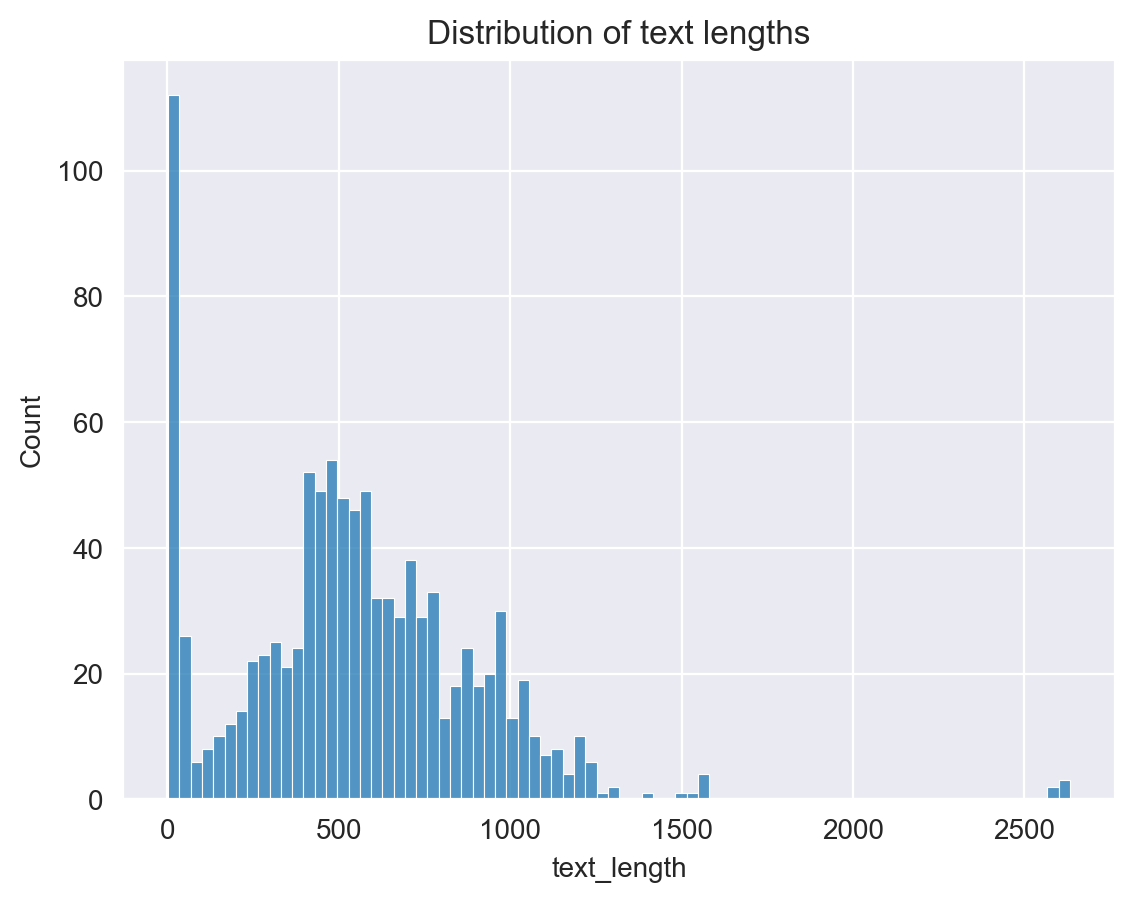

In [123]:
# create a new column with text lengths

lute_songs_df['text_length'] = lute_songs_df.song_text.apply(lambda x: len(x))

sns.histplot(data=lute_songs_df, x='text_length', bins=80)
plt.title('Distribution of text lengths')
plt.show()

The obvious spike close to zero probably consists of pieces that do not contain any English text, but where short bits of nonsense, annotations or texts in other languages where erroneously classified as English text. Thus, we drop all pices whose text length is shorter than 100 characters. Subsequently, we manually inspect (and possibly exclude) some of the remaining shorter texts. Since many pieces appear in  different versions which usually have the same text, we drop the duplicates with respect to the pieces' titles.

In [124]:
# for inspecting song texts below a certain text length (n)

def inspect_short_texts(df, n=200):
    for index, row in lute_songs_df.query(f'text_length < {n}').iterrows():
        print(index)
        print(row.song_text)
        print('\n')

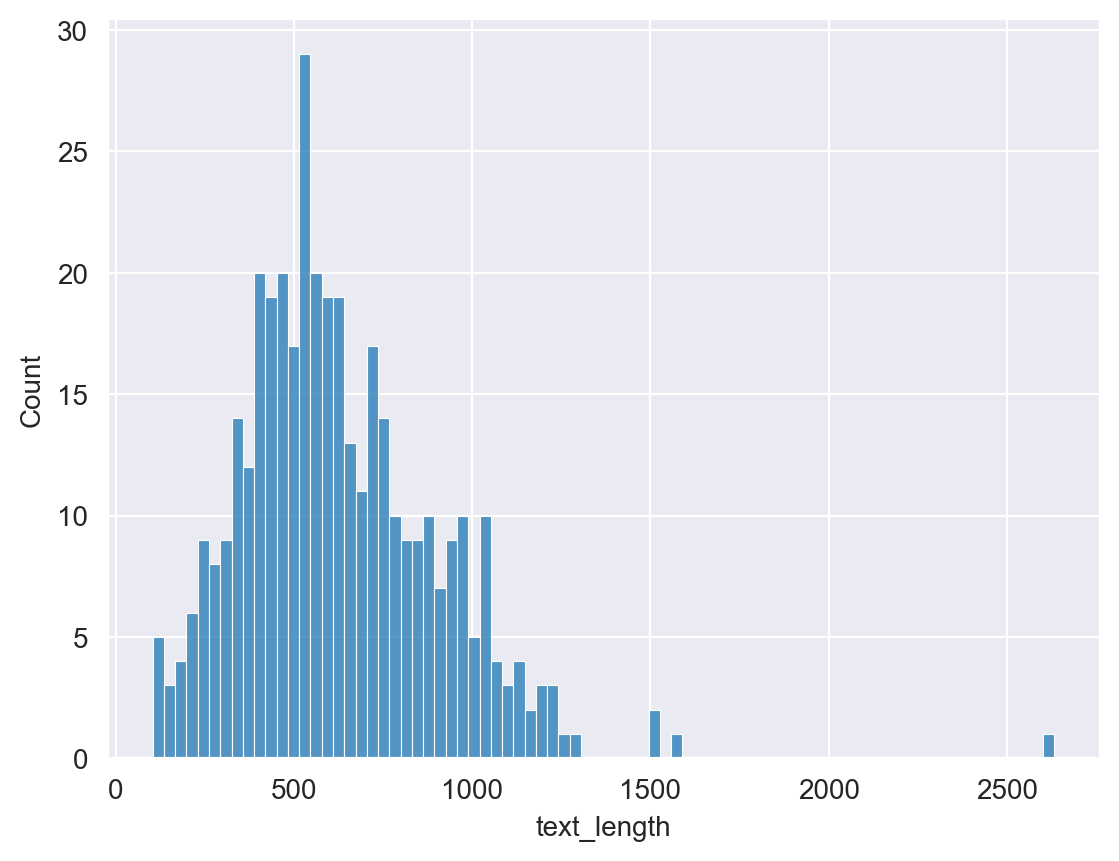

(392, 32)

In [125]:
# after inspecting the shorter song texts, we decide to drop all texts < 100 characters plus some selected longer texts

lute_songs_df = lute_songs_df[lute_songs_df.text_length > 100]
lute_songs_df = lute_songs_df.drop(labels=[256, 706, 1426, 1467, 1665, 1673, 1592])

# many pieces appear in  different versions which usually have the same text, so we drop the duplicates

lute_songs_df = lute_songs_df.drop_duplicates(subset=['Title'])

sns.histplot(data=lute_songs_df, x='text_length', bins=80)
plt.show()

# we shrinked our initial 1700 lute songs down to only 392

lute_songs_df.shape

We have excluded pieces without text, pieces with text that isn't in English and pieces that occur in different versions. Thus, we have reduced our dataset from 1740 to only 392 pieces.

In [128]:
lute_songs_path = os.path.join(wd, 'data', 'data_sets', 'lute_songs_with_text_cleaned.csv')
lute_songs_df.to_csv(lute_songs_path)